In [1]:
%load_ext autoreload
%autoreload 2

here the objective is to fit the logit graph model to multiple different graph domains and then visualize the original vs fitted graphs

In [2]:

import sys
import os

#Graph imports
sys.path.append('../..')
import src.graph as graph
import src.logit_estimator as estimator
import src.utils as utils
import src.model_selection as model_selection
import src.gic as gic
import src.param_estimator as pe
import src.graph as graph
import src.model_selection as ms

from src.simulation import LogitGraphFitter, GraphModelComparator

# usual imports
import matplotlib.pyplot as plt
import pickle
import math
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import gaussian_kde
import numpy as np
import pandas as pd
import seaborn as sns
import gc
import random
import networkx as nx
from numpy import errstate

from IPython.display import display
from pyvis.network import Network
from mpl_toolkits.axes_grid1 import make_axes_locatable


ModuleNotFoundError: No module named 'src.graph'

In [3]:
data_directory = f'../../data/REDDIT-MULTI-12K'
os.listdir(data_directory)

['REDDIT-MULTI-12K.graph_idx',
 'component_1975.edges',
 'component_2610.edges',
 'REDDIT-MULTI-12K.graph_labels',
 'REDDIT-MULTI-12K.readme',
 'readme.html',
 'component_3599.edges',
 'component_2848.edges',
 'component_3726.edges',
 'component_3586.edges',
 'component_3440.edges',
 'component_3235.edges',
 'component_4077.edges',
 'REDDIT-MULTI-12K.edges',
 'component_2156.edges']

In [4]:
def load_reddit_graph(data_dir, filename):
    """
    Loads a graph from the specified directory and filename.

    Args:
        data_dir (str): The directory where the data is stored.
        filename (str): The name of the file to load.

    Returns:
        networkx.Graph: The loaded graph as a networkx Graph object.
    """
    edge_file = os.path.join(data_dir, filename)
    
    G = nx.Graph()
    
    with open(edge_file, 'r') as f:
        for line in f:
            # The files are comma-separated, so we split the line
            # and convert the node IDs to integers.
            u, v = map(int, line.strip().split(','))
            G.add_edge(u, v)
            
    return G


graphs = []
graph_filepaths = {}
filename = 'REDDIT-MULTI-12K.edges'
graph = load_reddit_graph(data_directory, filename)
if graph:
    graphs.append(graph)
    graph_filepaths[graph] = os.path.join(data_directory, filename)
    print(f"Graph {filename} loaded successfully. Edges: {graph.number_of_edges()}, Nodes: {graph.number_of_nodes()}")


Graph REDDIT-MULTI-12K.edges loaded successfully. Edges: 5450243, Nodes: 4669027


In [6]:
graph = graphs[0]

import pandas as pd

# Calculate connected components
connected_components = list(nx.connected_components(graph))
component_data = []

# Collect data for each component
for i, component in enumerate(connected_components):
    subgraph = graph.subgraph(component)
    num_nodes = subgraph.number_of_nodes()
    num_edges = subgraph.number_of_edges()
    component_data.append({
        'component': i + 1,
        'num_nodes': num_nodes,
        'num_edges': num_edges
    })

# Create a DataFrame
component_df = pd.DataFrame(component_data)

In [7]:
component_df.sort_values(by='num_nodes', ascending=False).head(100)


,component,num_nodes,num_edges
21522,21523,3760,4058
21518,21519,3642,4003
10871,10872,3624,3766
26780,26781,3606,4334
31789,31790,3533,5166
...,...,...,...
30208,30209,2348,3457
4602,4603,2338,2798
3921,3922,2338,2587
5027,5028,2337,2582


In [8]:
import os
target_directory = data_directory
selected_components = component_df[(component_df['num_nodes'] >= 950) & (component_df['num_nodes'] <= 1050)]
selected_components = selected_components.head(10)
selected_components

,component,num_nodes,num_edges
1974,1975,976,1144
2155,2156,970,1076
2609,2610,976,1111
2847,2848,1034,1164
3234,3235,1042,1102
3439,3440,1022,1113
3585,3586,1012,1112
3598,3599,996,1094
3725,3726,957,1104
4076,4077,1007,1169


In [9]:
for index, row in selected_components.iterrows():
    component_index = row['component']
    component_nodes = connected_components[component_index - 1]
    subgraph = graph.subgraph(component_nodes)
    
    # Define the file path
    filepath = os.path.join(target_directory, f"component_{component_index}.edges")
    
    # Write the edges to the file
    with open(filepath, 'w') as f:
        for u, v in subgraph.edges():
            f.write(f"{u},{v}\n")
    
    print(f"Component {component_index} saved with {subgraph.number_of_nodes()} nodes and {subgraph.number_of_edges()} edges.")


Component 1975 saved with 976 nodes and 1144 edges.
Component 2156 saved with 970 nodes and 1076 edges.
Component 2610 saved with 976 nodes and 1111 edges.
Component 2848 saved with 1034 nodes and 1164 edges.
Component 3235 saved with 1042 nodes and 1102 edges.
Component 3440 saved with 1022 nodes and 1113 edges.
Component 3586 saved with 1012 nodes and 1112 edges.
Component 3599 saved with 996 nodes and 1094 edges.
Component 3726 saved with 957 nodes and 1104 edges.
Component 4077 saved with 1007 nodes and 1169 edges.


In [10]:
ids = []
for index, row in selected_components.iterrows():
    component_index = row['component']
    ids.append(component_index)
ids

[1975, 2156, 2610, 2848, 3235, 3440, 3586, 3599, 3726, 4077]

In [11]:
for id in ids:
    # load the graph
    graph_file = f'../../data/REDDIT-MULTI-12K/component_{id}.edges'
    g = nx.read_edgelist(graph_file, nodetype=int, delimiter=',')
    if g.number_of_nodes() == 0 or g.number_of_edges() == 0:
        print(f"Component {id} has no nodes or edges.")
    else:
        print(g.number_of_nodes(), g.number_of_edges())

976 1144
970 1076
976 1111
1034 1164
1042 1102
1022 1113
1012 1112
996 1094
957 1104
1007 1169


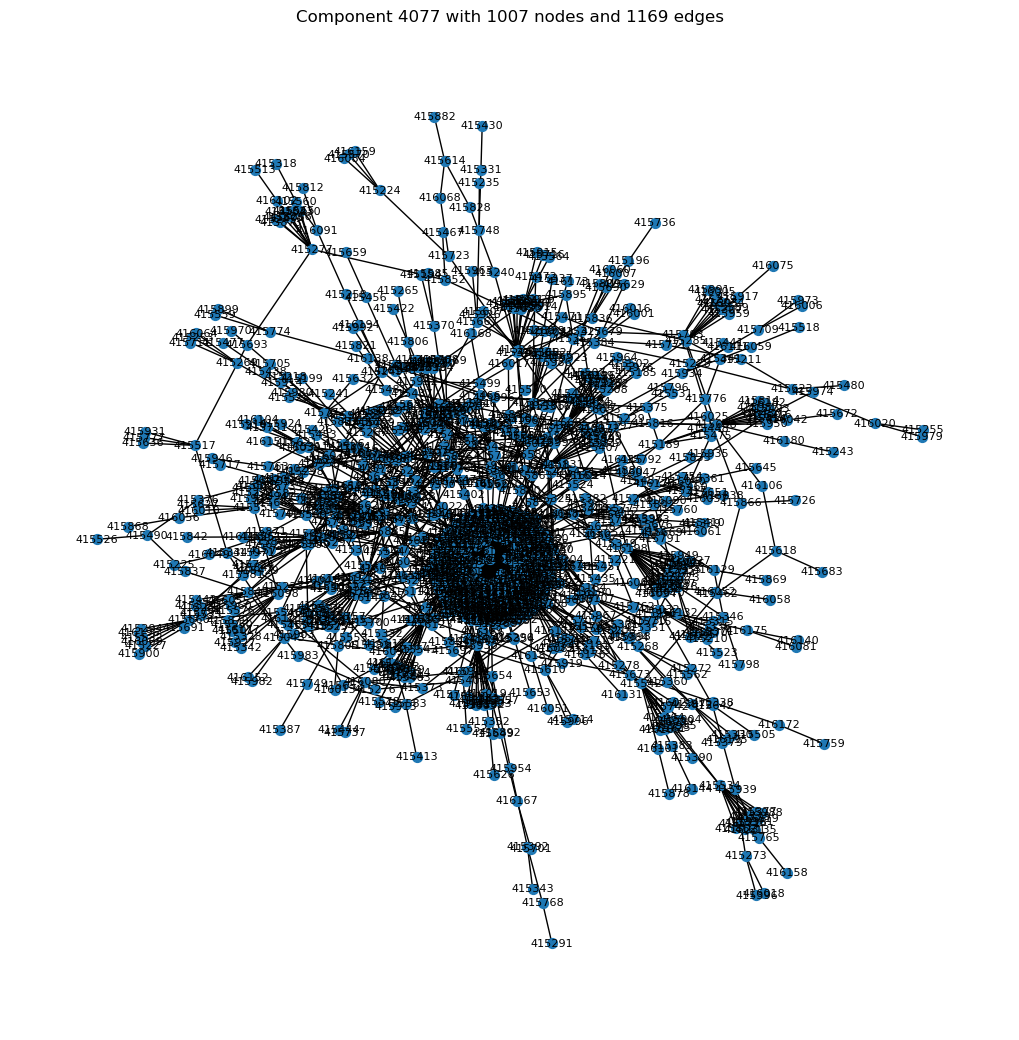

In [12]:
import matplotlib.pyplot as plt
import networkx as nx

# Load the graph from the saved file
filepath = os.path.join(target_directory, f"component_{component_index}.edges")
loaded_graph = nx.read_edgelist(filepath, delimiter=',', nodetype=int)

# Plot the loaded graph
plt.figure(figsize=(10, 10))
nx.draw(loaded_graph, with_labels=True, node_size=50, font_size=8)
plt.title(f"Component {component_index} with {loaded_graph.number_of_nodes()} nodes and {loaded_graph.number_of_edges()} edges")
plt.show()

### Fitting single graph

Loading the different graphs into a networkx graph

In [32]:
# Let's proceed with the first loaded graph if available
if not graphs:
    print("\nNo graphs were loaded. Exiting example.")
    exit()

target_graph = graphs[1]
target_filepath = graph_filepaths[target_graph]

# For a single fit, you need to specify a single `d`
fitter_params = {
    "d": 0,
    "n_iteration": 8000,
    "patience": 10,
    "er_p": 0.05,
    "edge_delta": 50,
    "min_gic_threshold": 0.1,
    "verbose": True
}

# Initialize the fitter with the parameters

lg_fitter = LogitGraphFitter(**fitter_params)
lg_fitter.fit(target_graph)



==================== Processing Graph ====================
Original graph - Nodes: 218, Edges: 1725
Running LG generation for d=0...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.2121
   📈 Results Summary
   🏆 Best iteration found: 634
   📊 Best spectrum difference: 196.9655
   🔗 Edges in best graph: 1776 (Real graph edges: 1725)
Fitting successful - GIC: 0.2101, Best iteration: 634
Fitted graph - Nodes: 218, Edges: 1776


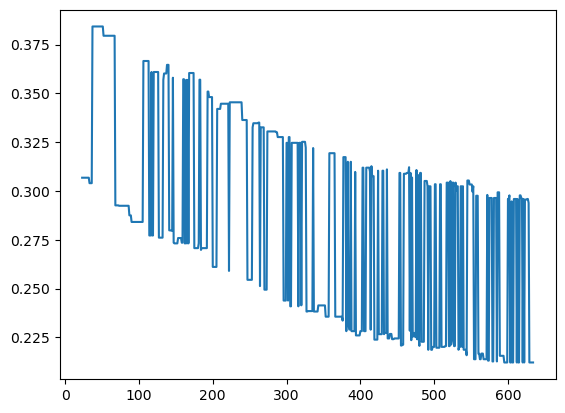

In [33]:
# Log the gic also with the spectrum digg and edges
plt.plot(lg_fitter.metadata['gic_values'])

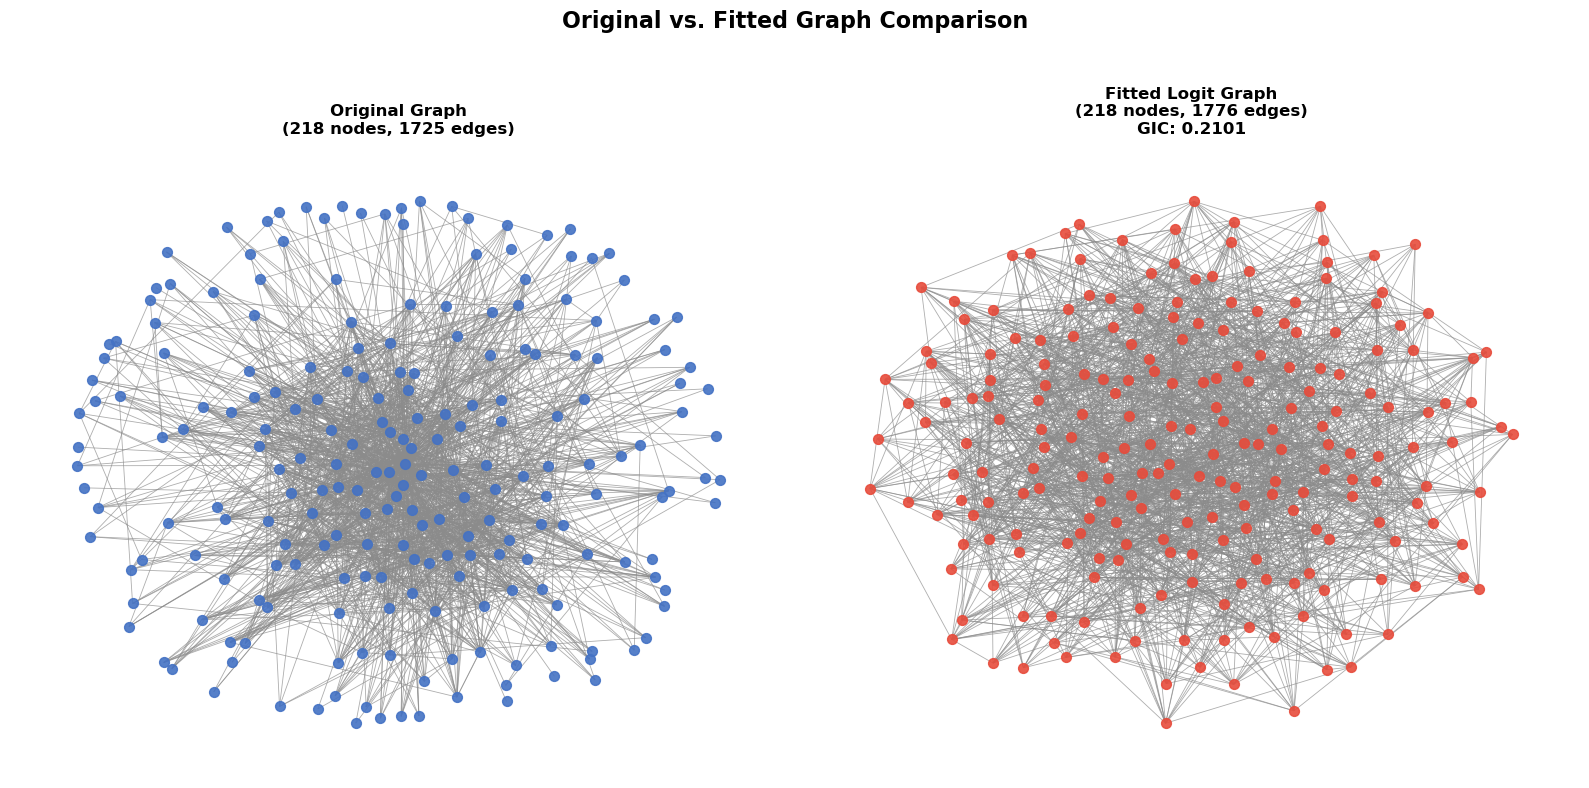

In [34]:
def compare_graphs_visually(original_graph, fitted_graph, metadata=None, figsize=(16, 8), node_size=50, edge_width=0.6):
    """
    Generates a side-by-side plot of the original and fitted graphs.

    Args:
        original_graph (nx.Graph): The original graph.
        fitted_graph (nx.Graph): The fitted graph (can be None if fitting failed).
        metadata (dict, optional): Fitting metadata to display in titles.
        figsize (tuple): The size of the matplotlib figure.
        node_size (int): The size of the nodes in the plot.
        edge_width (float): The width of the edges in the plot.

    Returns:
        matplotlib.figure.Figure: The figure object for the plot.
    """
    fig, axes = plt.subplots(1, 2, figsize=figsize)
    
    # Define colors and use a consistent layout for better comparison
    original_node_color = '#4472C4'
    fitted_node_color = '#E74C3C'
    edge_color = '#8B8B8B'
    
    # Calculate layout for original graph
    pos_orig = nx.spring_layout(original_graph, k=1, iterations=50, seed=42)
    
    # 1. Plot Original Graph
    ax_orig = axes[0]
    stats_orig = f"{original_graph.number_of_nodes()} nodes, {original_graph.number_of_edges()} edges"
    nx.draw_networkx_edges(original_graph, pos_orig, ax=ax_orig, edge_color=edge_color, width=edge_width, alpha=0.7)
    nx.draw_networkx_nodes(original_graph, pos_orig, ax=ax_orig, node_color=original_node_color, node_size=node_size, alpha=0.9)
    ax_orig.set_title(f'Original Graph\n({stats_orig})', fontweight='bold', pad=10)
    ax_orig.axis('off')

    # 2. Plot Fitted Graph
    ax_fitted = axes[1]
    title = 'Fitted Logit Graph'
    if fitted_graph and metadata and metadata.get('fit_success'):
        stats_fitted = f"{fitted_graph.number_of_nodes()} nodes, {fitted_graph.number_of_edges()} edges"
        gic_val = metadata.get('gic_value', 'N/A')
        gic_text = f"GIC: {gic_val:.4f}" if isinstance(gic_val, (int, float)) else f"GIC: {gic_val}"
        title = f'{title}\n({stats_fitted})\n{gic_text}'
        
        # Calculate separate layout for fitted graph to avoid position mismatch
        pos_fitted = nx.spring_layout(fitted_graph, k=1, iterations=50, seed=42)
        
        nx.draw_networkx_edges(fitted_graph, pos_fitted, ax=ax_fitted, edge_color=edge_color, width=edge_width, alpha=0.7)
        nx.draw_networkx_nodes(fitted_graph, pos_fitted, ax=ax_fitted, node_color=fitted_node_color, node_size=node_size, alpha=0.9)
    else:
        title = f'{title}\n(Fitting Failed)'
        ax_fitted.text(0.5, 0.5, 'Fitting Failed', horizontalalignment='center', verticalalignment='center', transform=ax_fitted.transAxes, fontsize=14, color='red')

    ax_fitted.set_title(title, fontweight='bold', pad=10)
    ax_fitted.axis('off')
    
    fig.suptitle('Original vs. Fitted Graph Comparison', fontsize=16, fontweight='bold')
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    
    return fig


# 5. Visualize the results
if lg_fitter.metadata['fit_success']:
    comparison_figure = compare_graphs_visually(target_graph, lg_fitter.fitted_graph, lg_fitter.metadata)
    plt.show()
else:
    print("Fitting failed. No visualization available.")


In [50]:
# Let's proceed with the first loaded graph if available
if not graphs:
    print("\nNo graphs were loaded. Exiting example.")
    exit()

target_graph = graphs[2]
target_filepath = graph_filepaths[target_graph]

# For a single fit, you need to specify a single `d`
sim_params = {
    "d_list": [0, 1, 2],
    "lg_params": {
        "max_iterations": 8000,
        "patience": 10,
        "gic_dist_type": 'KL',
        "er_p": 0.05,
        "min_gic_threshold": 0.1,
        "edge_delta": 50,
        "verbose": True,
    },
    "other_model_n_runs": 5,
    "other_model_params": [
        {'lo': 0.01, 'hi': 0.2},  # ER (probability)
        {'k': {'lo': 2, 'hi': 3, 'step': 1}, 'p': {'lo': 0.01, 'hi': 0.2}},  # WS
        {'lo': 1, 'hi': 3},      # GRG (alpha)
        {'lo': 3, 'hi': 5},     # BA (m)
    ],
    "verbose": True,
}



# Initialize the fitter with the parameters

comparator = GraphModelComparator(**sim_params)
comparator.compare(target_graph, target_filepath)



============================== Processing Graph: 96907622.edges ==============================

--- Fitting Logit Graph (LG) model ---
Running LG generation for d=0...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.4346 (Target: ≤0.1) 📈 Best Spectrum Diff: 572.4733 ⏱️  Patience: 0/10 🔗 Edges: 1766 (Target: 4649)
📊 Iteration 2,000: 🎯 GIC (KL): 0.3615 (Target: ≤0.1) 📈 Best Spectrum Diff: 474.1305 ⏱️  Patience: 0/10 🔗 Edges: 2633 (Target: 4649)
📊 Iteration 3,000: 🎯 GIC (KL): 0.4667 (Target: ≤0.1) 📈 Best Spectrum Diff: 403.6383 ⏱️  Patience: 0/10 🔗 Edges: 3453 (Target: 4649)
📊 Iteration 4,000: 🎯 GIC (KL): 0.2190 (Target: ≤0.1) 📈 Best Spectrum Diff: 358.5826 ⏱️  Patience: 0/10 🔗 Edges: 4234 (Target: 4649)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.4033
   📈 Results Summary
   🏆 Best iteration found: 4,584
   📊 Best spectrum difference: 348.8605
   🔗 Edges in best graph: 4674 (Real graph edges: 4649)
d=0: GIC=0.2042, sigma=-5.4737
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.4181 (Target: ≤0.1) 📈 Best Spectrum Diff: 566.4874 ⏱️  Patience: 0/10 🔗 Edges: 1813 (Target: 4649)
📊 Iteration 2,000: 🎯 GIC (KL): 0.5644 (Target: ≤0.1) 📈 Best Spectrum Diff: 471.9589 ⏱️  Patience: 0/10 🔗 Edges: 2678 (Target: 4649)
📊 Iteration 3,000: 🎯 GIC (KL): 0.4667 (Target: ≤0.1) 📈 Best Spectrum Diff: 400.6161 ⏱️  Patience: 0/10 🔗 Edges: 3511 (Target: 4649)
📊 Iteration 4,000: 🎯 GIC (KL): 0.2135 (Target: ≤0.1) 📈 Best Spectrum Diff: 359.2674 ⏱️  Patience: 0/10 🔗 Edges: 4275 (Target: 4649)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.4069
   📈 Results Summary
   🏆 Best iteration found: 4,528
   📊 Best spectrum difference: 351.4274
   🔗 Edges in best graph: 4660 (Real graph edges: 4649)
d=1: GIC=0.4069, sigma=-6.2316
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.4336 (Target: ≤0.1) 📈 Best Spectrum Diff: 569.1227 ⏱️  Patience: 0/10 🔗 Edges: 1812 (Target: 4649)
📊 Iteration 2,000: 🎯 GIC (KL): 0.5529 (Target: ≤0.1) 📈 Best Spectrum Diff: 471.6666 ⏱️  Patience: 0/10 🔗 Edges: 2689 (Target: 4649)
📊 Iteration 3,000: 🎯 GIC (KL): 0.2589 (Target: ≤0.1) 📈 Best Spectrum Diff: 404.2305 ⏱️  Patience: 0/10 🔗 Edges: 3486 (Target: 4649)
📊 Iteration 4,000: 🎯 GIC (KL): 0.2111 (Target: ≤0.1) 📈 Best Spectrum Diff: 364.2727 ⏱️  Patience: 0/10 🔗 Edges: 4277 (Target: 4649)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.4048
   📈 Results Summary
   🏆 Best iteration found: 4,409
   📊 Best spectrum difference: 358.2911
   🔗 Edges in best graph: 4577 (Real graph edges: 4649)
d=2: GIC=0.2048, sigma=-80.5871
Best LG fit found with GIC: 0.2042

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.2723181008317491
Tes

In [52]:
comparator.summary_df

,graph_filename,model,gic_value,param,fit_success,nodes,edges,density,avg_clustering,avg_path_length,diameter,assortativity,num_components,largest_component_size
0,96907622.edges,Original,NaN,N/A,True,187,4649,0.267322,0.598147,1.749955,4,-0.223390,2,183
1,96907622.edges,LG,0.204187,"d=0, sigma=-5.4737",True,187,4674,0.268760,0.269265,1.731240,2,-0.021158,1,187
2,96907622.edges,ER,0.272318,0.2,True,187,3385,0.194641,0.196904,1.806107,3,-0.001703,1,187
3,96907622.edges,BA,0.721498,5.0,True,187,910,0.052326,0.129281,2.433673,4,-0.115371,1,187
4,96907622.edges,WS,1.599264,20.2,True,187,4675,0.268817,0.266414,1.731183,2,-0.042454,1,187
5,96907622.edges,GRG,2.135166,1.0,True,187,16891,0.971249,0.975021,1.028751,2,-0.046187,1,187


### Comparison other models

comparing multiple models

In [15]:
sim_params = {
    "d_list": [0, 1, 2],
    "lg_params": {
        "max_iterations": 8000,
        "patience": 10,
        "gic_dist_type": 'KL',
        "er_p": 0.001,
        "min_gic_threshold": 0.1,
        "edge_delta": 50,
        "verbose": True,
    },
    "other_model_n_runs": 5,
    "other_model_params": [
        {'lo': 0.01, 'hi': 0.2},  # ER (probability)
        {'k': {'lo': 2, 'hi': 3, 'step': 1}, 'p': {'lo': 0.01, 'hi': 0.2}},  # WS
        {'lo': 1, 'hi': 3},      # GRG (alpha)
        {'lo': 3, 'hi': 5},     # BA (m)
    ],
    "verbose": True,
}



graph_files = []
for id in ids:
    graph_files.append(f'../../data/REDDIT-MULTI-12K/component_{id}.edges')
print(len(graph_files))

graphs = [nx.read_edgelist(f, nodetype=int) for f in graph_files]


10


In [16]:

comparators = []
folder_name = 'runs/fitted_graphs_comparison_reddit1'
os.makedirs(folder_name, exist_ok=True)

for graph_file in graph_files:
    try:
        print(f"Loading graph from: {graph_file}")
        original_graph = nx.read_edgelist(graph_file, nodetype=int, delimiter=',')

        n_iteration = 10_000
        sim_params['lg_params']['max_iterations'] = n_iteration

        # Run the comparison
        comparator = GraphModelComparator(**sim_params)
        comparator.compare(original_graph, graph_file)
    except Exception as e:
        print(f"Error graph from {graph_file}: {e}")
        continue

    comparators.append(comparator)
    import pickle
    graph_name = graph_file.split('/')[-1].split('.')[0]
    with open(f'{folder_name}/comparators_{graph_name}.pkl', 'wb') as f:
        pickle.dump(comparators, f)



Loading graph from: ../../data/REDDIT-MULTI-12K/component_1975.edges

============================== Processing Graph: component_1975.edges ==============================

--- Fitting Logit Graph (LG) model ---
Running LG generation for d=0...


🔄 Optimizing Graph:   0%|          | 0/10000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.4334 (Target: ≤0.1) 📈 Best Spectrum Diff: 401.4165 ⏱️  Patience: 0/10 🔗 Edges: 1190 (Target: 1144)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.4342
   📈 Results Summary
   🏆 Best iteration found: 658
   📊 Best spectrum difference: 401.4165
   🔗 Edges in best graph: 901 (Real graph edges: 1144)
d=0: GIC=0.5086, sigma=-1.3885
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/10000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.4878 (Target: ≤0.1) 📈 Best Spectrum Diff: 401.6406 ⏱️  Patience: 0/10 🔗 Edges: 1072 (Target: 1144)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.4721
   📈 Results Summary
   🏆 Best iteration found: 951
   📊 Best spectrum difference: 401.6406
   🔗 Edges in best graph: 1031 (Real graph edges: 1144)
d=1: GIC=0.4946, sigma=-7.8725
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/10000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.4844
   📈 Results Summary
   🏆 Best iteration found: 613
   📊 Best spectrum difference: 403.2927
   🔗 Edges in best graph: 907 (Real graph edges: 1144)
d=2: GIC=0.5389, sigma=-8.1056
Best LG fit found with GIC: 0.4946

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 6.261068586539377
Testing the selected model for WS
WS gic: 0.6382471875895034
Testing the selected model for GRG
GRG gic: 8.554468655397844
Testing the selected model for BA
BA gic: 1.7382149575522132
WS fitting - GIC: 0.6382, Param: 20.1789
BA fitting - GIC: 1.7382, Param: 3.8889
ER fitting - GIC: 6.2611, Param: 0.0522
GRG fitting - GIC: 8.5545, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/REDDIT-MULTI-12K/component_2156.edges

============================== Processing Graph: component_2156.edges ============

🔄 Optimizing Graph:   0%|          | 0/10000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.4573
   📈 Results Summary
   🏆 Best iteration found: 691
   📊 Best spectrum difference: 406.3730
   🔗 Edges in best graph: 969 (Real graph edges: 1076)
d=0: GIC=0.5405, sigma=-1.4558
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/10000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.5617 (Target: ≤0.1) 📈 Best Spectrum Diff: 405.8419 ⏱️  Patience: 0/10 🔗 Edges: 930 (Target: 1076)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.5010
   📈 Results Summary
   🏆 Best iteration found: 1,099
   📊 Best spectrum difference: 405.3197
   🔗 Edges in best graph: 1014 (Real graph edges: 1076)
d=1: GIC=0.5391, sigma=-7.8311
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/10000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.4783
   📈 Results Summary
   🏆 Best iteration found: 780
   📊 Best spectrum difference: 405.4504
   🔗 Edges in best graph: 943 (Real graph edges: 1076)
d=2: GIC=0.5663, sigma=-7.6842
Best LG fit found with GIC: 0.5391

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 6.196513500379303
Testing the selected model for WS
WS gic: 0.6758560392141917
Testing the selected model for GRG
GRG gic: 7.274162915884419
Testing the selected model for BA
BA gic: 1.8416638339003466
WS fitting - GIC: 0.6759, Param: 20.1789
BA fitting - GIC: 1.8417, Param: 3.4444
ER fitting - GIC: 6.1965, Param: 0.0522
GRG fitting - GIC: 7.2742, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/REDDIT-MULTI-12K/component_2610.edges

============================== Processing Graph: component_2610.edges ============

🔄 Optimizing Graph:   0%|          | 0/10000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.5122
   📈 Results Summary
   🏆 Best iteration found: 548
   📊 Best spectrum difference: 439.9868
   🔗 Edges in best graph: 869 (Real graph edges: 1111)
d=0: GIC=0.5830, sigma=-1.2716
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/10000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.4882 (Target: ≤0.1) 📈 Best Spectrum Diff: 438.7963 ⏱️  Patience: 0/10 🔗 Edges: 1027 (Target: 1111)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.4864
   📈 Results Summary
   🏆 Best iteration found: 987
   📊 Best spectrum difference: 438.7963
   🔗 Edges in best graph: 1017 (Real graph edges: 1111)
d=1: GIC=0.4908, sigma=-8.3482
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/10000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.5533 (Target: ≤0.1) 📈 Best Spectrum Diff: 440.1435 ⏱️  Patience: 0/10 🔗 Edges: 1104 (Target: 1111)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.5328
   📈 Results Summary
   🏆 Best iteration found: 912
   📊 Best spectrum difference: 440.1435
   🔗 Edges in best graph: 1024 (Real graph edges: 1111)
d=2: GIC=0.5716, sigma=-8.1132
Best LG fit found with GIC: 0.4908

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 6.005001381744106
Testing the selected model for WS
WS gic: 0.6904088830395742
Testing the selected model for GRG
GRG gic: 7.011583571475627
Testing the selected model for BA
BA gic: 1.7701416150139568
WS fitting - GIC: 0.6904, Param: 20.1789
BA fitting - GIC: 1.7701, Param: 3.6667
ER fitting - GIC: 6.0050, Param: 0.0522
GRG fitting - GIC: 7.0116, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from:

🔄 Optimizing Graph:   0%|          | 0/10000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.5805
   📈 Results Summary
   🏆 Best iteration found: 804
   📊 Best spectrum difference: 493.3603
   🔗 Edges in best graph: 1143 (Real graph edges: 1164)
d=0: GIC=0.6057, sigma=-1.1168
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/10000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.5676 (Target: ≤0.1) 📈 Best Spectrum Diff: 493.0365 ⏱️  Patience: 0/10 🔗 Edges: 1086 (Target: 1164)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.5551
   📈 Results Summary
   🏆 Best iteration found: 1,103
   📊 Best spectrum difference: 492.4295
   🔗 Edges in best graph: 1165 (Real graph edges: 1164)
d=1: GIC=0.5525, sigma=-8.9840
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/10000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.6059 (Target: ≤0.1) 📈 Best Spectrum Diff: 493.7648 ⏱️  Patience: 0/10 🔗 Edges: 1167 (Target: 1164)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.5902
   📈 Results Summary
   🏆 Best iteration found: 974
   📊 Best spectrum difference: 493.7648
   🔗 Edges in best graph: 1145 (Real graph edges: 1164)
d=2: GIC=0.6094, sigma=-9.4011
Best LG fit found with GIC: 0.5525

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 5.634761940303169
Testing the selected model for WS
WS gic: 0.7583795320248355
Testing the selected model for GRG
GRG gic: 6.514918660480705
Testing the selected model for BA
BA gic: 1.764890988956032
WS fitting - GIC: 0.7584, Param: 20.2000
BA fitting - GIC: 1.7649, Param: 3.0000
ER fitting - GIC: 5.6348, Param: 0.0522
GRG fitting - GIC: 6.5149, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: 

🔄 Optimizing Graph:   0%|          | 0/10000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.6100
   📈 Results Summary
   🏆 Best iteration found: 474
   📊 Best spectrum difference: 541.9168
   🔗 Edges in best graph: 904 (Real graph edges: 1102)
d=0: GIC=0.6815, sigma=-1.0883
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/10000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.6297 (Target: ≤0.1) 📈 Best Spectrum Diff: 538.2722 ⏱️  Patience: 0/10 🔗 Edges: 1027 (Target: 1102)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.6205
   📈 Results Summary
   🏆 Best iteration found: 868
   📊 Best spectrum difference: 538.2722
   🔗 Edges in best graph: 941 (Real graph edges: 1102)
d=1: GIC=0.6621, sigma=-9.2570
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/10000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.6334
   📈 Results Summary
   🏆 Best iteration found: 746
   📊 Best spectrum difference: 541.2354
   🔗 Edges in best graph: 958 (Real graph edges: 1102)
d=2: GIC=0.6876, sigma=-7.6114
Best LG fit found with GIC: 0.6621

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 5.456221684921055
Testing the selected model for WS
WS gic: 0.7833137661996946
Testing the selected model for GRG
GRG gic: 6.145307601688464
Testing the selected model for BA
BA gic: 1.9819247378030456
WS fitting - GIC: 0.7833, Param: 20.1578
BA fitting - GIC: 1.9819, Param: 3.6667
ER fitting - GIC: 5.4562, Param: 0.0522
GRG fitting - GIC: 6.1453, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/REDDIT-MULTI-12K/component_3440.edges

============================== Processing Graph: component_3440.edges ============

🔄 Optimizing Graph:   0%|          | 0/10000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.6249
   📈 Results Summary
   🏆 Best iteration found: 543
   📊 Best spectrum difference: 533.5015
   🔗 Edges in best graph: 945 (Real graph edges: 1113)
d=0: GIC=0.7061, sigma=-1.0904
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/10000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.7358 (Target: ≤0.1) 📈 Best Spectrum Diff: 532.3947 ⏱️  Patience: 0/10 🔗 Edges: 996 (Target: 1113)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.6354
   📈 Results Summary
   🏆 Best iteration found: 916
   📊 Best spectrum difference: 532.3947
   🔗 Edges in best graph: 943 (Real graph edges: 1113)
d=1: GIC=0.7379, sigma=-9.3160
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/10000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.6596
   📈 Results Summary
   🏆 Best iteration found: 953
   📊 Best spectrum difference: 532.9741
   🔗 Edges in best graph: 1161 (Real graph edges: 1113)
d=2: GIC=0.6529, sigma=-7.9842
Best LG fit found with GIC: 0.6529

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 5.143427159976781
Testing the selected model for WS
WS gic: 0.8254729058055533
Testing the selected model for GRG
GRG gic: 5.8451697186414435
Testing the selected model for BA
BA gic: 3.978388721751092
WS fitting - GIC: 0.8255, Param: 20.1789
BA fitting - GIC: 3.9784, Param: 5.0000
ER fitting - GIC: 5.1434, Param: 0.0522
GRG fitting - GIC: 5.8452, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/REDDIT-MULTI-12K/component_3586.edges

============================== Processing Graph: component_3586.edges ===========

🔄 Optimizing Graph:   0%|          | 0/10000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.5135
   📈 Results Summary
   🏆 Best iteration found: 668
   📊 Best spectrum difference: 495.7295
   🔗 Edges in best graph: 1132 (Real graph edges: 1112)
d=0: GIC=0.5157, sigma=-1.1585
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/10000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.5380 (Target: ≤0.1) 📈 Best Spectrum Diff: 496.1530 ⏱️  Patience: 0/10 🔗 Edges: 1066 (Target: 1112)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.4825
   📈 Results Summary
   🏆 Best iteration found: 796
   📊 Best spectrum difference: 496.1530
   🔗 Edges in best graph: 927 (Real graph edges: 1112)
d=1: GIC=0.5792, sigma=-8.6035
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/10000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.5200
   📈 Results Summary
   🏆 Best iteration found: 701
   📊 Best spectrum difference: 495.3203
   🔗 Edges in best graph: 935 (Real graph edges: 1112)
d=2: GIC=0.5821, sigma=-7.7875
Best LG fit found with GIC: 0.5157

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 6.025160344390888
Testing the selected model for WS
WS gic: 0.7038041245988826
Testing the selected model for GRG
GRG gic: 7.000047808835825
Testing the selected model for BA
BA gic: 1.8676335648941533
WS fitting - GIC: 0.7038, Param: 20.1156
BA fitting - GIC: 1.8676, Param: 3.2222
ER fitting - GIC: 6.0252, Param: 0.0522
GRG fitting - GIC: 7.0000, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/REDDIT-MULTI-12K/component_3599.edges

============================== Processing Graph: component_3599.edges ============

🔄 Optimizing Graph:   0%|          | 0/10000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.6160
   📈 Results Summary
   🏆 Best iteration found: 749
   📊 Best spectrum difference: 575.6650
   🔗 Edges in best graph: 1104 (Real graph edges: 1094)
d=0: GIC=0.6327, sigma=-0.9840
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/10000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.6653 (Target: ≤0.1) 📈 Best Spectrum Diff: 573.9224 ⏱️  Patience: 0/10 🔗 Edges: 955 (Target: 1094)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.5942
   📈 Results Summary
   🏆 Best iteration found: 1,128
   📊 Best spectrum difference: 573.4335
   🔗 Edges in best graph: 1056 (Real graph edges: 1094)
d=1: GIC=0.6157, sigma=-10.0101
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/10000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.6266
   📈 Results Summary
   🏆 Best iteration found: 848
   📊 Best spectrum difference: 575.3089
   🔗 Edges in best graph: 1105 (Real graph edges: 1094)
d=2: GIC=0.6409, sigma=-9.1613
Best LG fit found with GIC: 0.6157

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 5.608911882909455
Testing the selected model for WS
WS gic: 0.7930503561981259
Testing the selected model for GRG
GRG gic: 6.366281545153813
Testing the selected model for BA
BA gic: 1.5588039549093515
WS fitting - GIC: 0.7931, Param: 20.2000
BA fitting - GIC: 1.5588, Param: 3.0000
ER fitting - GIC: 5.6089, Param: 0.0522
GRG fitting - GIC: 6.3663, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/REDDIT-MULTI-12K/component_3726.edges

============================== Processing Graph: component_3726.edges ===========

🔄 Optimizing Graph:   0%|          | 0/10000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.4124
   📈 Results Summary
   🏆 Best iteration found: 805
   📊 Best spectrum difference: 347.4040
   🔗 Edges in best graph: 1037 (Real graph edges: 1104)
d=0: GIC=0.4570, sigma=-1.7066
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/10000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.4367 (Target: ≤0.1) 📈 Best Spectrum Diff: 347.0791 ⏱️  Patience: 0/10 🔗 Edges: 1076 (Target: 1104)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.3962
   📈 Results Summary
   🏆 Best iteration found: 999
   📊 Best spectrum difference: 347.0791
   🔗 Edges in best graph: 1076 (Real graph edges: 1104)
d=1: GIC=0.4341, sigma=-7.2662
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/10000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.4778 (Target: ≤0.1) 📈 Best Spectrum Diff: 347.0247 ⏱️  Patience: 0/10 🔗 Edges: 1033 (Target: 1104)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.4505
   📈 Results Summary
   🏆 Best iteration found: 1,129
   📊 Best spectrum difference: 346.4327
   🔗 Edges in best graph: 1154 (Real graph edges: 1104)
d=2: GIC=0.4552, sigma=-8.3299
Best LG fit found with GIC: 0.4341

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 6.422490869744786
Testing the selected model for WS
WS gic: 0.6231424022033185
Testing the selected model for GRG
GRG gic: 7.738487609115754
Testing the selected model for BA
BA gic: 1.803929437675341
WS fitting - GIC: 0.6231, Param: 20.1789
BA fitting - GIC: 1.8039, Param: 3.0000
ER fitting - GIC: 6.4225, Param: 0.0522
GRG fitting - GIC: 7.7385, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from

🔄 Optimizing Graph:   0%|          | 0/10000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.2902 (Target: ≤0.1) 📈 Best Spectrum Diff: 268.9621 ⏱️  Patience: 0/10 🔗 Edges: 1178 (Target: 1169)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.2809
   📈 Results Summary
   🏆 Best iteration found: 1,033
   📊 Best spectrum difference: 268.2255
   🔗 Edges in best graph: 1209 (Real graph edges: 1169)
d=0: GIC=0.2830, sigma=-2.0394
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/10000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.3022 (Target: ≤0.1) 📈 Best Spectrum Diff: 269.2814 ⏱️  Patience: 0/10 🔗 Edges: 1186 (Target: 1169)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.2943
   📈 Results Summary
   🏆 Best iteration found: 1,014
   📊 Best spectrum difference: 269.2645
   🔗 Edges in best graph: 1199 (Real graph edges: 1169)
d=1: GIC=0.2985, sigma=-6.9494
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/10000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.3309
   📈 Results Summary
   🏆 Best iteration found: 726
   📊 Best spectrum difference: 268.3377
   🔗 Edges in best graph: 1029 (Real graph edges: 1169)
d=2: GIC=0.3609, sigma=-7.4524
Best LG fit found with GIC: 0.2830

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 7.987820276880721
Testing the selected model for WS
WS gic: 0.44941661249732884
Testing the selected model for GRG
GRG gic: 9.246990128279396
Testing the selected model for BA
BA gic: 2.177200855325257
WS fitting - GIC: 0.4494, Param: 20.2000
BA fitting - GIC: 2.1772, Param: 3.0000
ER fitting - GIC: 7.9878, Param: 0.0311
GRG fitting - GIC: 9.2470, Param: 1.0000

--- Calculating graph attributes ---


In [37]:
21321

21321